In [1]:
%matplotlib inline
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# libraries
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from mpl_toolkits import mplot3d

**PSD, FFT**

number of channels = 2
length = 162.23453514739228s


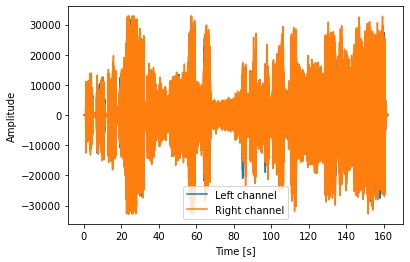

In [2]:
import music_time_series as mts
rho = mts.musdat()[100000:110000]
rho = rho / max(rho)

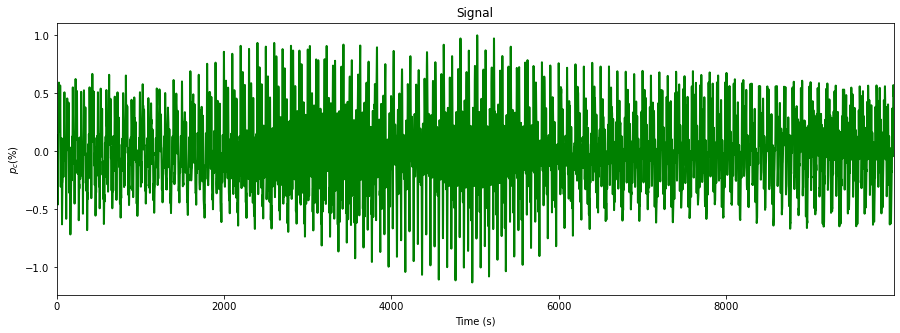

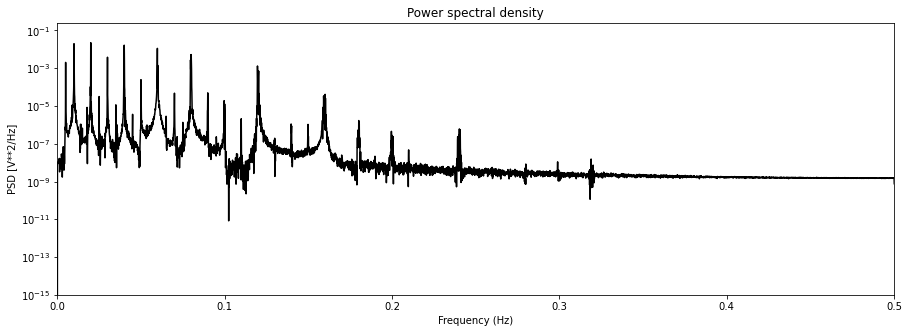

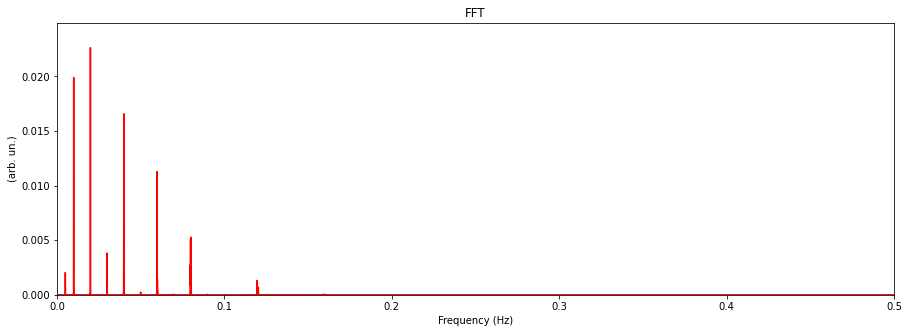

In [3]:
# name of the file
name = 'best_777_T_Bz=5A_Bx=0.08A_exc810_det852.3_5mW_5K_sigma+_PEM_(30min).txt'

# load data
exp_data = np.loadtxt(name, skiprows=1, delimiter='\t')
#t = exp_data[:,0]
#rho = exp_data[:,3]

t = np.arange(0, len(rho), 1)

# fft
sp = np.fft.fft(rho)
freq_fft = np.fft.fftfreq(t.shape[-1])
power_fft = (sp.real)**2
power_fft[0] = 0
freq, power = signal.periodogram(rho, scaling='spectrum')
#freq, power = signal.welch(rho, scaling='spectrum')

# signal
plt.figure(figsize=(15, 5))
plt.title(r'Signal')
plt.ylabel("$p_c$(%)")
plt.xlabel("Time (s)")
plt.plot(t, rho, 'g', lw=2)
plt.xlim([0, max(t)])
plt.show()

# power spectrum
plt.figure(figsize=(15, 5))
plt.title(r'Power spectral density')
plt.semilogy(freq, power, 'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD [V**2/Hz]')
axes = plt.gca()
axes.set_xlim([0, 0.5])
axes.set_ylim([10**-15, max(power)+max(power)*10])
plt.show()

# fft
plt.figure(figsize=(15, 5))
plt.title(r'FFT')
plt.plot(freq, power, 'r')
axes = plt.gca()
axes.set_xlim([0,0.5])
axes.set_ylim([0,max(power)+max(power)*0.1])
axes.fill_between(freq, 0, power, facecolor='red')
plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'(arb. un.)')
plt.show()

**Autocorrelation**

The autocorrelation of a signal describes the similarity of a signal against a time-shifted version of itself. For a signal $x$, the autocorrelation $r$ is:
$$r(k)=\sum_nx(n)x(n−k)$$
 
In this equation, $k$ is often called the lag parameter.  $r(k)$ is maximized at  $k=0$ and is symmetric about $k$.
The autocorrelation is useful for finding repeated patterns in a signal. For example, at short lags, the autocorrelation can tell us something about the signal's fundamental frequency.

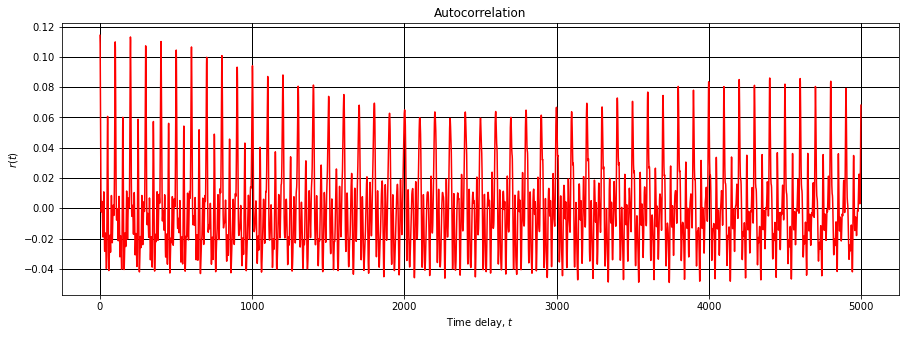

In [4]:
N = len(rho)
fvi = np.fft.fft(rho, n=2*N)
acf = np.real(np.fft.ifft(fvi * np.conjugate(fvi))[:N])
acf = acf / (N - np.arange(N))

plt.figure(figsize=(15, 5))
plt.title(r'Autocorrelation')
plt.xlabel(r'Time delay, $t$')
plt.ylabel(r'$r(t)$')
plt.plot(t[0:len(acf) - int(len(acf) / 2)], acf[0:len(acf) - int(len(acf) / 2)], 'r')
plt.grid(color='black', linewidth=1)
plt.show()

**Embedding time**

The time delayed mutual information was suggested by Fraser and Swinney as a tool to determine a reasonable delay: Unlike the autocorrelation function, the mutual information takes into account also nonlinear correlations. One has to compute
$$
S = - \sum_{ij} p_{ij}(\tau) ln \frac{p_{ij}(\tau)}{p_ip_j}, 
$$
where for some partition on the real numbers $p_{ij}$ is the probability to find a time series value in the $i$-th interval, and $p_{ij}(\tau)$ is the joint probability that an observation falls into the $i$-th interval and the observation time $\tau$ later falls into the $j$-th. In theory this expression has no systematic dependence on the size of the partition elements and can be quite easily computed. There exist good arguments that if the time delayed mutual information exhibits a marked minimum at a certain value of $\tau$, then this is a good candidate for a reasonable time delay. However, these arguments have to be modified when the embedding dimension exceeds two. Moreover, as will become transparent in the following sections, not all applications work optimally with the same delay. Since we are not really interested in absolute values of the mutual information here but rather in the first minimum, the minimal implementation given here seems to be sufficient.

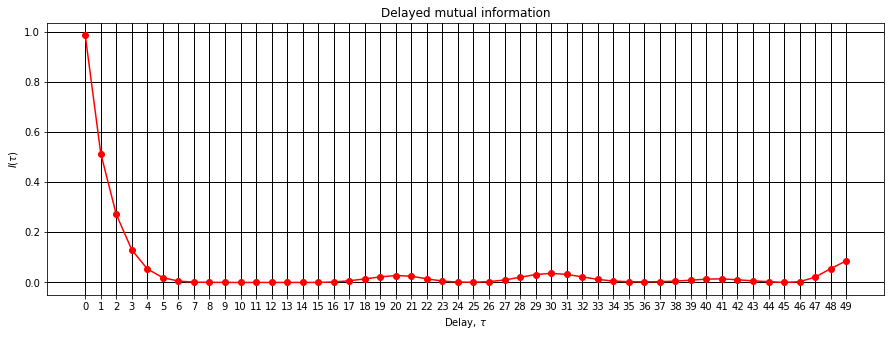

In [5]:
def mut(x, y, bins=32):
    """
    Calculates mutual information, I = S(x) + S(y) - S(x,y), between x and y.
    Here, S(x) is the Shannon entropy.
    _____
    Input (x : array, y : array, bins : int {bins for histogram})
    Output (i : float {mutual information})
    """
    p_x = np.histogram(x, bins)[0]
    p_y = np.histogram(y, bins)[0]
    p_xy = np.histogram2d(x, y, bins)[0].flatten()

    # convert frequencies into  the probabilities
    p_x = p_x[p_x > 0] / np.sum(p_x)
    p_y = p_y[p_y > 0] / np.sum(p_y)
    p_xy = p_xy[p_xy > 0] / np.sum(p_xy)

    # calculate the Shannon entropies
    Sh_x = np.sum(p_x * np.log2(p_x))
    Sh_y = np.sum(p_y * np.log2(p_y))
    Sh_xy = np.sum(p_xy * np.log2(p_xy))

    return Sh_xy - Sh_x - Sh_y


def tdmut(x, tau, bins=32):
    """
    Calculate the time-delayed mutual information.
    _____
    Input (x : array {1d time series}, tau : int {maximal time delay}, bins : int {bins for histogram})
    Output (arr : float {array with the time-delayed mutual information})
    """
    tau_max = min(len(x), tau)
    arr = np.empty(tau_max)
    arr[0] = mut(x, x, bins)

    for i in range(1, tau_max):
        arr[i] = mut(x[:-i], x[i:], bins)

    return arr


calc_range = 50
mutual_inf = tdmut(rho, tau=calc_range, bins=2)

plt.figure(figsize=(15, 5))
plt.plot(mutual_inf, 'ro-')
plt.xticks(np.arange(0, calc_range, 1.0))
plt.grid(color='black', linewidth=1)
plt.title(r'Delayed mutual information')
plt.xlabel(r'Delay, $\tau$')
plt.ylabel(r'$I(\tau)$')
plt.show()

**Phase space reconstruction**

In [6]:
from ipywidgets import interact, FloatSlider

# delay
r_delay = 8

# filter
#sos = signal.butter(2, 0.5, 'lp', output='sos')
#rho1 = signal.sosfilt(sos, rho)
b, a = signal.butter(5, 0.2)
rho1 = signal.filtfilt(b, a, rho)

X = rho[:-r_delay*2]
Y = rho[r_delay:-r_delay]
Z = rho[2*r_delay:]

plt.rcParams["figure.figsize"] = [10, 10]

# rotation step
step=2

def turn(xx,yy):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    #ax.set_xlabel(r'$x(t)$')
    #ax.set_ylabel(r'$x(t + \tau)$')
    #ax.set_zlabel(r'$x(t + 2\tau)$');
    ax.view_init(xx, yy)
    ax.plot(X[::step], Y[::step], Z[::step],'-r', lw=0.5)
    ax.scatter(X, Y, Z, c=np.sqrt(X**2+Y**2), cmap='magma', s=10)
    ax.set_facecolor('k')
    plt.axis('off')
    plt.show()
    #plt.savefig(name+'3D1'+'.pdf')
    
interact(turn, xx=FloatSlider(value=55, min=0, max=360, step=1),
         yy=FloatSlider(value=75, min=0, max=90, step=1))

interactive(children=(FloatSlider(value=55.0, description='xx', max=360.0, step=1.0), FloatSlider(value=75.0, …

<function __main__.turn(xx, yy)>

**Correlation sum and correlation dimension**

There are several ways to to quantify the self-similarity of a geometrical object by a dimension, i.e. correlated dimension.
The correlation sum for a collection of pints $x_n$ in some vector space to be the fraction of all possible pairs of points which are closer than a given distance $\epsilon$ in a particular norm. The basic formula is 
$$
C(\epsilon) = \frac{2}{N(N-1)} \sum_{i=1}^N \sum_{j=i+1}^N \Theta (\epsilon -||x_i - x_j||),
$$
where $\Theta$ is Heaviside step function. The sum just counts the pairs $(x_i,x_j)$ whose distance is smaller than $\epsilon$. In the limit of an infinite amount of data ($N \rightarrow \infty$) and for smaller $\epsilon$, $C$ scales like a power law, $C(\epsilon) \sim \epsilon^D$, and the correlated dimension defined as
$$
d(N,\epsilon) = \frac{\partial \mathrm{ln} C (\epsilon,N)}{\partial  \mathrm{ln} \epsilon}, \\
        D = \lim\limits_{\epsilon \to 0} \lim\limits_{N \to \infty} d(N, \epsilon).
$$
Instead of directly inspecting the correlation sum plots, it is often customary to plot the local slope,
$$
        D_2^{(d)} = \frac{d log C_2^{(d)} (r)}{d log r},
$$
as a function of $r$ in order to identify this scaling region. Scaling at extreme length scales is often impaired by “edge effects,” i.e., at very small length scales, noise and poor statistics create fluctuations in $D_2^{(d)}(r)$, and at very large length scales, finiteness of attractor size causes it to drop to zero. A scaling region with a fairly constant $D_2(d)$ is generally found at intermediate length scales sandwiched between these two extremes. If the time series comes out of a low-dimensional chaotic process, then one expects $D_2(d)$ to converge to the $D_2$ of the underlying attractor within a sufficiently small $d$ (i.e., at the minimum embedding dimension). On the other hand, for stochastic processes, the delay vectors fill up the phase space, causing $D_2(d)$ to diverge with $d$. For the special case of uncorrelated noise, $D_2(d)$ would be equal to $d$.

-> *Correlation sum*

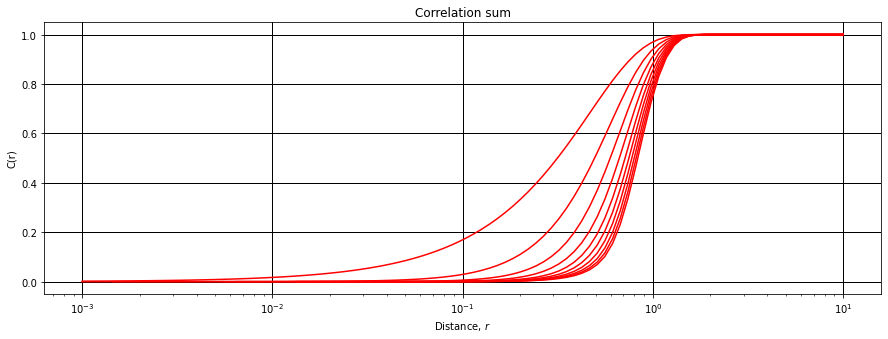

In [8]:
from scipy.spatial import distance

def delayed_vectros(x, dim, tau):
    """
    Calculates the time-delayed vectors from a time series.
    _____
    Input (x : array {time series}, dim : int {embedding dimension}, tau : int {time delay})
    Output (n-dim array {time-delayed array})
    """
    m = len(x) - tau * (dim - 1)
        
    return np.asarray([x[i:i + tau * (dim - 1) + 1:tau] for i in range(m)])


def c2(x, start=0.001, end=10, step=100, window=1):
    """
    Computation the correlation sum of the time series using Grassberger & Procaccia algorithm(1983).
    _____
    Input (x : n-dim array {points in the phase space}, start : int {starting point of the progression}, 
           stop : int {ending point of the progression}, step : int {number of points between start and end},
           window : int {Theiler window})
    Output (r : array {distances for which correlation sums is calculated}, c2 : array {correlation sum C(r)})
    """
    ratio = (end / start) ** (1.0 / (step - 1))
    r = start * ratio ** np.arange(step)
    r = np.asarray(r)
    r = np.sort(r[r > 0])
    
    bins = np.insert(r, 0, -1)
    c = np.zeros(len(r))
    
    for i in range(len(x) - window - 1):
        dists = distance.cdist([x[i]], x[i + window + 1:], metric='chebyshev')[0]
        c += np.histogram(dists, bins=bins)[0]
        
    pairs = 0.5 * (len(x) - window - 1) * (len(x) - window)
    c = np.cumsum(c) / pairs
    
    return r[c > 0], c[c > 0]

# number of calculated embedding dimension:
m0 = 10
dim = np.arange(1, m0 + 1)

vectors = [delayed_vectros(rho1, d, r_delay) for d in dim]

plt.figure(figsize=(15, 5))
plt.title(r'Correlation sum')
plt.xlabel(r'Distance, $r$')
plt.ylabel(r'C(r)')

for v in vectors:
    x, y = c2(v)
    plt.semilogx(x, y, 'r')
    
plt.grid(color='black', linewidth=1)
plt.show()

-> *Correlation dimension*

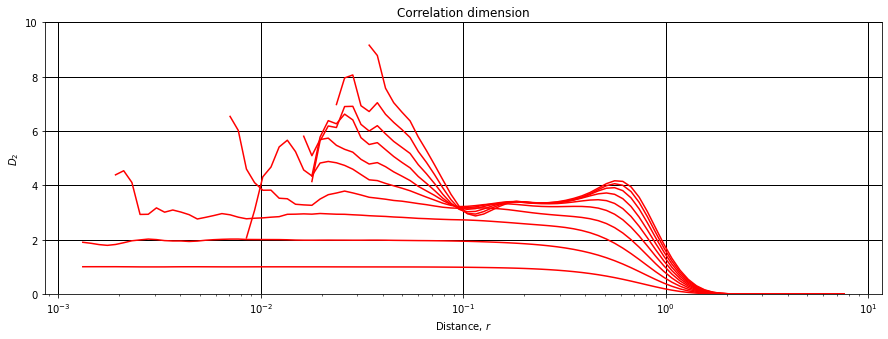

In [9]:
def d2(r, c2, window=10):
    """
    Computation the correlation dimension of the time series (C(r) ~ r^D2).
    _____
    Input (x : array {distances for which correlation sums is been calculated}, c2 : array {correlation sums}, 
           window : int {Theiler window})
    Output (d2 : array {average D2 at each distance})
    """
    hwin = 3
    N = len(r) - 2 * hwin
    d2 = np.empty(N)
    x, y = np.log(r), np.log(c2)

    for i in range(N):
        p, q = x[i:i + 2 * hwin + 1], y[i:i + 2 * hwin + 1]
        A = np.vstack([p, np.ones(2 * hwin + 1)]).T
        d2[i] = np.linalg.lstsq(A, q)[0][0]

    return d2


plt.figure(figsize=(15, 5))
plt.title(r'Correlation dimension')
plt.xlabel(r'Distance, $r$')
plt.ylabel(r'$D_2$')

for v in vectors:
    x, y = c2(v)
    plt.semilogx(x[3:-3], d2(x, y), 'r')
    
axes = plt.gca()
axes.set_ylim([0, 10])
plt.grid(color='black', linewidth=1)
plt.show()

**Lyapunov exponents**


Lyapunov exponents evaluate the sensitive dependence to initial conditions considering the exponential divergence of nearby orbits. Therefore, it is necessary to evaluate how trajectories with nearby initial conditions diverge. The dynamics of the system transforms the $D$-sphere of states in a $D$-ellipsoid and, mathematically, the Lyapunov exponents considers $d(t) = d_0b^{\lambda t}$, where $b$ is a reference basis. The signs of the Lyapunov exponents provide a qualitative picture of the system’s dynamics. The existence of positive Lyapunov exponents defines directions of local instabilities in the system dynamics. The determination of Lyapunov exponents of dynamical system with an explicitly mathematical model, which can be linearized, is well established from the algorithm proposed by Wolf et al. On the other hand, the determination of these exponents from time series is quite more complex. 

The average of effective Lyapunov exponent along the trajectory is the true Lyapunov exponent and the maximum value is given by
$$
\lambda(t)=\lim_{x \to \infty} \frac{1}{\delta} \mathrm{ln} \frac{|u(t+\delta)-u_\epsilon (t+\delta)|}{\epsilon}
$$
where $|u(0)−u_\epsilon(0)| = \epsilon$ and $u(t)−u_\epsilon(t) = \epsilon v_u(t)$, with $v_u(t)$ representing the eigenvectors associated with the maximum Lyapunov exponent, $\lambda_{max}$; $\delta$ is a relative time referring to the
time index of the point where the distance begin to be greater than $\epsilon$, $\delta(0)$.

If $\lambda$ is positive, this means an exponential divergence of nearby trajectories, i.e. chaos.
In dissipative systems one can also find a negative maximal Lyapunov exponent which reflects the existence of a stable fixed point. Two trajectories which approach th fixed point also approach each other exponentially fast. If the motion down onto a limit cycle, two trajectories can only separate or approach each other slower than exponentially. In this case the maximal Lyapunov exponent is zero and the motion is called marginally stable.

 The Lyapunov exponent describes the rate of separation of two infinitesimally close trajectories of a dynamical system in phase space. In a chaotic system, these trajectories diverge exponentially following the equation:
$|X(t, X_0) - X(t, X_0 + \epsilon)| = |\epsilon| e^{\lambda t}$.

In this equation $X(t, X_0)$ is the trajectory of the system $X$ starting at the point $X_0$ in phase space at time $t$. $\epsilon$ is the (infinitesimal) difference vector and $\lambda$ is called the Lyapunov exponent. If the system has more than one free variable, the phase space is multidimensional and each dimension has its own Lyapunov exponent. The existence of at least one positive Lyapunov exponent is generally seen as a strong indicator for chaos.

In [10]:
def lyapunov(data, emb_dim=3, matrix_dim=3, tau=r_delay):
    """
    Estimates the Lyapunov exponents for the given data using the algorithm of Eckmann et al.
    _____
    Input (x : array {time series}, emb_dim : int {embedding dimension}, 
           matrix_dim : int {matrix dimension}, tau : float {step size of the data in seconds})
    Output (lexp : array {array of matrix_dim Lyapunov exponents})
    """
    data = np.asarray(data)
    n = len(data)
    
    if (emb_dim - 1) % (matrix_dim - 1) != 0:
        raise ValueError("(emb_dim - 1) must be divisible by the (matrix_dim - 1)!")
    
    m = (emb_dim - 1) // (matrix_dim - 1)
    min_nb = min(2 * matrix_dim, matrix_dim + 4)
    vec_delay = delayed_vectros(x=data, dim=emb_dim, tau=r_delay)
    mat_Q_id = np.identity(matrix_dim)
    lexp = np.zeros(matrix_dim, dtype="float32")
    lexp_counts = np.zeros(lexp.shape)
    
    for i in range(len(vec_delay)):
        # neighbors for each vector
        diffs = np.max(np.abs(vec_delay - vec_delay[i]), axis=1)
        # all neighbors that are too close in time to the vector itself
        diffs[max(0, i):min(len(diffs), i + 1)] = np.inf
        indices = np.argsort(diffs)
        idx = indices[min_nb - 1]  # index of the min_nb-nearest neighbor
        r = diffs[idx]  # corresponding distance
        # there may be more than min_nb vectors having a distance of equal to r
        indices = np.where(diffs <= r)[0]
        # emb_dim = (d_M - 1) * m + 1
        mat_X = np.array([data[j:j + emb_dim:m] for j in indices])
        mat_X -= data[i:i + emb_dim:m]
        # vector for linear least squares
        vector = data[indices + matrix_dim * m] - data[i + matrix_dim * m]
        a, _, _, _ = np.linalg.lstsq(mat_X, vector, rcond=-1)
        # matrix T = 
        # 0  1  0  ... 0
        # 0  0  1  ... 0
        # ...
        # 0  0  0  ... 1
        # a1 a2 a3 ... a_(d_M)
        mat_T = np.zeros((matrix_dim, matrix_dim))
        mat_T[:-1, 1:] = np.identity(matrix_dim - 1)
        mat_T[-1] = a
        # QR-decomposition of T * mat_Q_id
        mat_Q, mat_R = np.linalg.qr(np.dot(mat_T, mat_Q_id))
        # force diagonal of R to be positive (if QR = A then also QLL'R = A with L' = L^-1)
        sign_diag = np.sign(np.diag(mat_R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
        mat_Q = np.dot(mat_Q, sign_diag)
        mat_R = np.dot(sign_diag, mat_R)
        mat_Q_id = mat_Q
        # sum for Lyapunov exponents
        diag_R = np.diag(mat_R)
        # drop zeros in mat_R
        idx = np.where(diag_R > 0)
        lexp_i = np.zeros(diag_R.shape, dtype="float32")
        lexp_i[idx] = np.log(diag_R[idx])
        lexp_i[np.where(diag_R == 0)] = np.inf
        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1

    # normalize exponents over number of individual mat_Rs
    idx = np.where(lexp_counts > 0)
    lexp[idx] /= lexp_counts[idx]
    lexp[np.where(lexp_counts == 0)] = np.inf
    # normalize with respect to tau
    lexp /= tau
    # normalize with respect to m
    lexp /= m
    return lexp

l_exp = list(lyapunov(rho, emb_dim=3, matrix_dim=3, tau=r_delay))
print('Lyapunov exponents:' + str(l_exp))

Lyapunov exponents:[0.017207058, -0.001402608, -0.06217206]


**Kaplan–Yorke conjecture**

In applied mathematics, the Kaplan–Yorke conjecture concerns the dimension of an attractor, using Lyapunov exponents. By arranging the Lyapunov exponents in order from largest to smallest $\lambda_1 \geq \lambda_2 \geq \ldots \lambda_n$, let j be the index for which
$$
\sum^{j}_{i=1} \lambda_i \geq 0
$$
and
$$
\sum^{j+1}_{i=1} \lambda_i < 0.
$$
Then the conjecture is that the dimension of the attractor is
$$
D = j + \frac{\sum^{j}_{i=1} \lambda_i}{|\lambda_{j+1}|}.
$$

In [12]:
# arranging the Lyapunov exponents in order from largest to smallest 
l_exp.sort(reverse=True)

k = 0

while True:
    if l_exp[k]>=0 and l_exp[k+1] < 0:
        # dimension
        D = k + 1 + sum(l_exp[0:k+1]) / abs(l_exp[k+1])
        print(f'The Kaplan–Yorke dimension of the attractor is {round(D, 3)}.')
        break
    
    k += 1

The Kaplan–Yorke dimension of the attractor is 13.268.
